# Computing Zonal Stats

This notebook finds and displays the mean slopes of roads in U District and Downtown using a slope raster and road edges.

## Part 1: Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import xarray as xr
import rasterstats
import contextily as ctx

## Part 2: Loading in data

### 2.1 Seattle slope raster

In [2]:
seattle_slope_raster ='/home/jovyan/seattle-micromobility/seattle_slope_lowres.tif'

In [3]:
seattle_slope = rxr.open_rasterio(seattle_slope_raster).squeeze()
seattle_slope = seattle_slope.where(seattle_slope != seattle_slope.rio.nodata) #masking no data values

#### Plotting to make sure it looks good:

Text(0.5, 1.0, 'Seattle Slope Map')

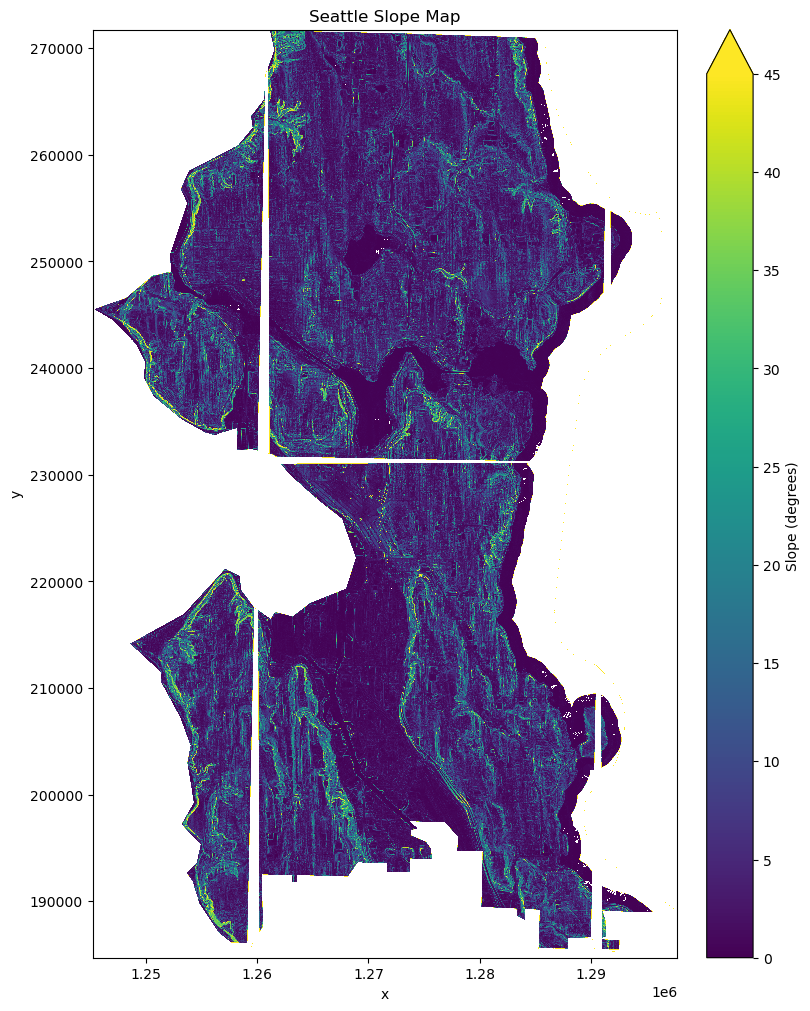

In [142]:
f, ax = plt.subplots(1,1, figsize=(8, 10), layout='constrained')

seattle_slope.plot.imshow(ax=ax,vmin=0, vmax=45, cbar_kwargs={'label':'Slope (degrees)'}, robust=True)
ax.set_title('Seattle Slope Map')

### 2.2 Seattle Neighborhood Boundaries

In [4]:
alt_neighborhood_boundaries = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/refs/heads/master/data/neighborhoods.geojson"

seattle_alt_gdf = gpd.read_file(
    alt_neighborhood_boundaries,
    engine='pyogrio'
)

#making sure the crs matches the raster
seattle_alt_gdf.to_crs(seattle_slope.rio.crs, inplace=True)

#creating separate gdfs for the locations we are interested in
seattle_udistrict = seattle_alt_gdf[seattle_alt_gdf['nhood']=='University District']
seattle_downtown = seattle_alt_gdf[seattle_alt_gdf['nhood']=='Downtown']

### 2.3 Seattle road edges

In [5]:
seattle_road_path = '/home/jovyan/seattle-micromobility/seattle_road_edges.geojson'
seattle_road_gdf = gpd.read_file(seattle_road_path).to_crs(seattle_slope.rio.crs) #making sure crs matches raster

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field service: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


#### Plotting to make sure it looks good:

<Axes: >

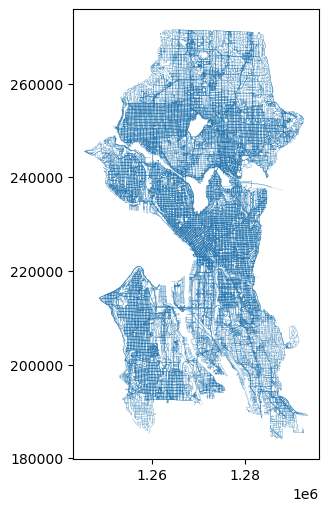

In [144]:
f, ax = plt.subplots(1,1, figsize=(5, 5), layout='constrained')
seattle_road_gdf.plot(ax=ax, linewidth=.1)

## Part 3: Computing and plotting slope statistics

### 3.1 Picking which roads to analyze

#### U District!

In [6]:
roads_clipped_to_udistrict = seattle_road_gdf.clip(seattle_udistrict)

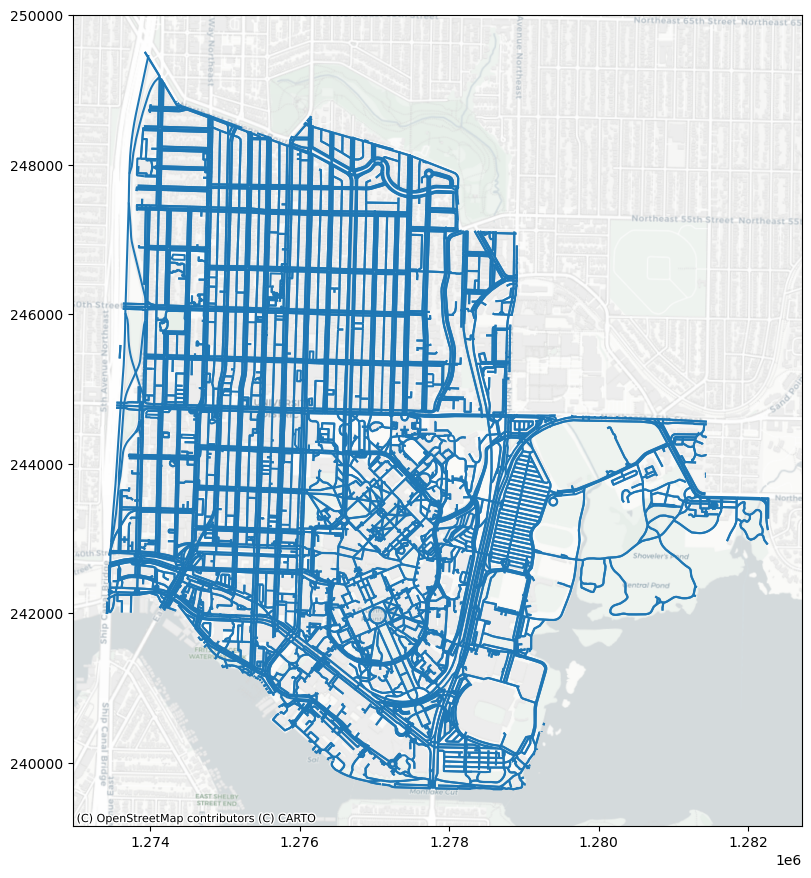

In [99]:
f, ax = plt.subplots(1,1, figsize=(8, 10), layout='constrained')
roads_clipped_to_udistrict.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=seattle_slope.rio.crs, source=ctx.providers.CartoDB.Positron)

#### Downtown!

In [7]:
roads_clipped_to_downtown = seattle_road_gdf.clip(seattle_downtown)

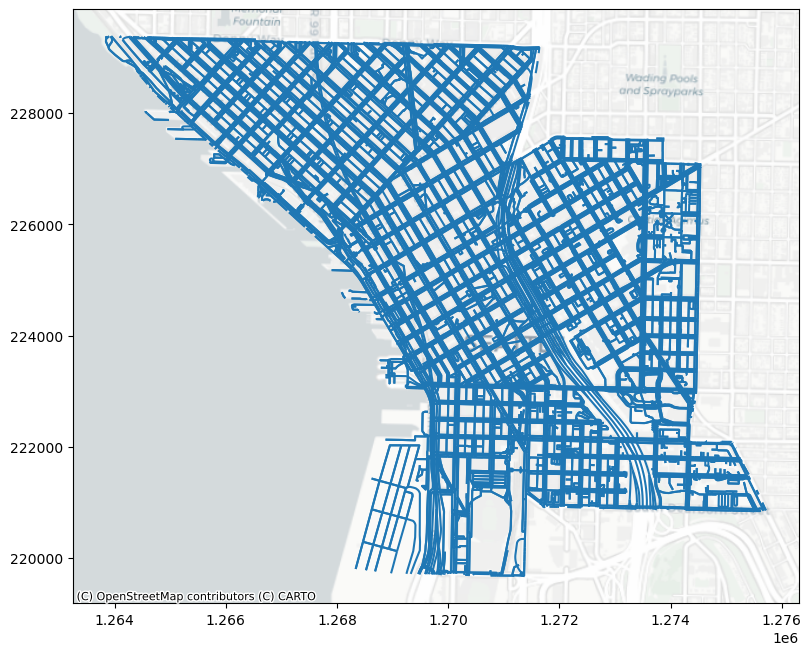

In [103]:
f, ax = plt.subplots(1,1, figsize=(8, 10), layout='constrained')
roads_clipped_to_downtown.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=seattle_slope.rio.crs, source=ctx.providers.CartoDB.Positron)

### 3.2 Creating the buffers and using zonal stats

#### U District!

In [8]:
#creating the buffer
buffer_ft = 10
buffer = roads_clipped_to_udistrict.buffer(buffer_ft) #10 ft
udistrict_buffer_gdf = gpd.GeoDataFrame(roads_clipped_to_udistrict.copy(), geometry=buffer)

In [9]:
#calculating slope mean and std using zonal stats
stats = rasterstats.zonal_stats(udistrict_buffer_gdf.geometry, seattle_slope.values,
                                affine=seattle_slope.rio.transform(),
                                nodata=seattle_slope.rio.nodata,
                                stats=['mean', 'std'])

In [10]:
#putting the stats as columns in the gdf
udistrict_buffer_gdf = udistrict_buffer_gdf.assign(slope_mean=[s['mean'] for s in stats], slope_std=[s['std'] for s in stats])

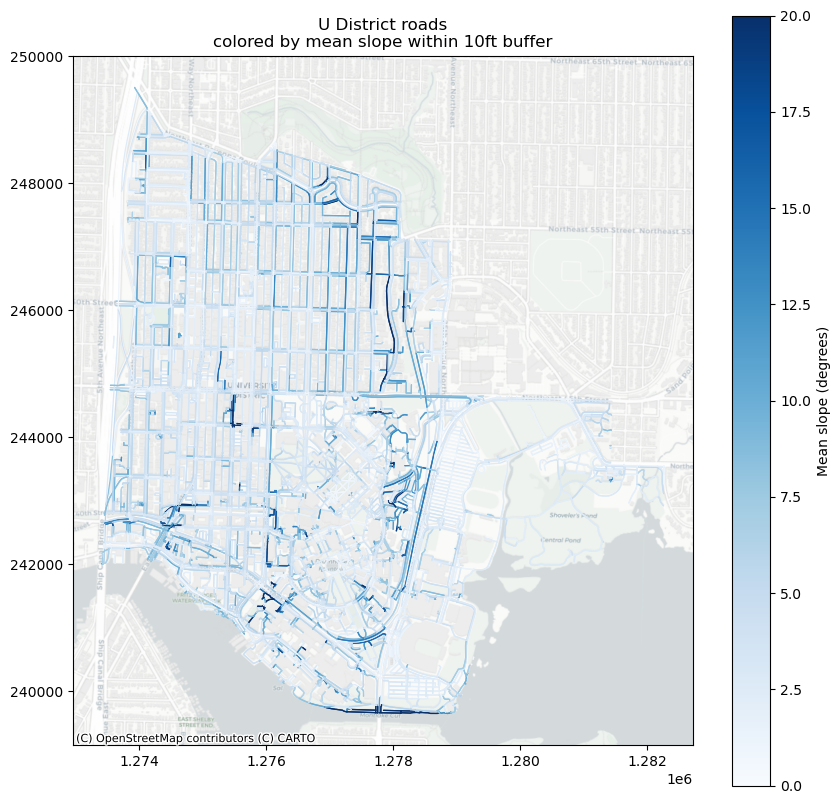

In [11]:
f,ax=plt.subplots(figsize=(10,10))
udistrict_buffer_gdf.plot(ax=ax, cmap='Blues', column='slope_mean', legend=True, vmin=0,vmax=20, linewidth=.5,legend_kwds={'label': "Mean slope (degrees)"})
ctx.add_basemap(ax, crs=seattle_slope.rio.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title(f'U District roads\ncolored by mean slope within {buffer_ft}ft buffer')
ax.set_aspect('equal')

#### Downtown!

In [12]:
#creating the buffer
buffer_ft = 10
buffer = roads_clipped_to_downtown.buffer(buffer_ft) #10 ft
downtown_buffer_gdf = gpd.GeoDataFrame(roads_clipped_to_downtown.copy(), geometry=buffer)

In [13]:
#calculating slope mean and std using zonal stats
stats = rasterstats.zonal_stats(downtown_buffer_gdf.geometry, seattle_slope.values,
                                affine=seattle_slope.rio.transform(),
                                nodata=seattle_slope.rio.nodata,
                                stats=['mean', 'std'])

In [14]:
#putting the stats as columns in the gdf
downtown_buffer_gdf = downtown_buffer_gdf.assign(slope_mean=[s['mean'] for s in stats], slope_std=[s['std'] for s in stats])

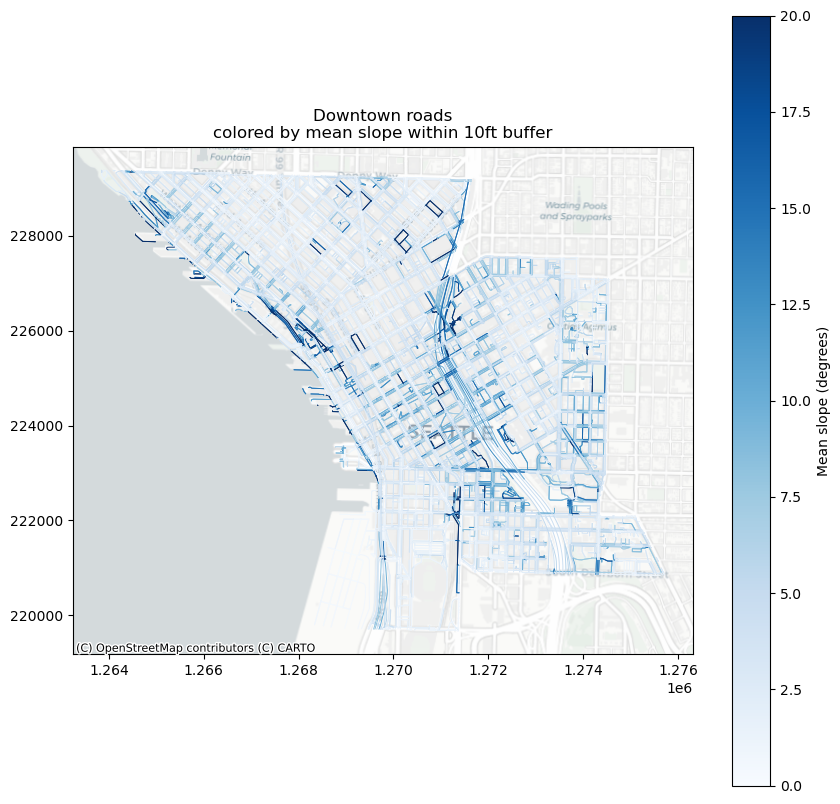

In [15]:
f,ax=plt.subplots(figsize=(10,10))
downtown_buffer_gdf.plot(ax=ax, cmap='Blues', column='slope_mean', legend=True, vmin=0,vmax=20, linewidth=.5,legend_kwds={'label': "Mean slope (degrees)"})
ctx.add_basemap(ax, crs=seattle_slope.rio.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title(f'Downtown roads\ncolored by mean slope within {buffer_ft}ft buffer')
ax.set_aspect('equal')